In [1]:
!pip install SciencePlots

  Using cached SciencePlots-2.1.1-py3-none-any.whl.metadata (11 kB)
Using cached SciencePlots-2.1.1-py3-none-any.whl (16 kB)


In [3]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from stock_env import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,trx_plot

from pprint import pprint
import scienceplots
import sys
sys.path.append("../FinRL-Library")

plt.style.use('science')

In [4]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [5]:
import yahoo_fin.stock_info as si
ticks = si.tickers_ftse100(True)
display(ticks.head(100))

Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.


,Company,Ticker,FTSE industry classification benchmark sector[25]
0,3i,III,Financial services
1,Admiral Group,ADM,Insurance
2,Airtel Africa,AAF,Telecommunications services
3,Anglo American plc,AAL,Mining
4,Antofagasta plc,ANTO,Mining
...,...,...,...
95,Vistry Group,VTY,Home Construction
96,Vodafone Group,VOD,Mobile telecommunications
97,Weir Group,WEIR,Industrial goods and services
98,Whitbread,WTB,Retail hospitality


In [6]:
ticks_from_setctors = ticks.groupby('FTSE industry classification benchmark sector[25]',as_index=False).first().iloc[:,[2]]
ticks['FTSE industry classification benchmark sector[25]'].value_counts()

FTSE industry classification benchmark sector[25]
Financial services                                    7
Support services                                      7
Media                                                 6
Banks                                                 5
Household goods & home construction                   5
Mining                                                5
Pharmaceuticals & biotechnology                       4
Life insurance                                        4
Travel & leisure                                      4
Multiline utilities                                   4
Real estate investment trusts                         3
Food & drug retailing                                 3
Aerospace & defence                                   3
Retailers                                             3
Oil & gas producers                                   2
Tobacco                                               2
Telecommunications services                           

In [7]:
ticks_from_setctors

,Ticker
0,BA
1,BARC
2,CCH
3,CRDA
4,FCIT
5,MNDI
6,SSE
7,HLMA
8,III
9,MKS


In [6]:
from elegantrl.agents import AgentDQN 

In [8]:
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2023-12-30'
TEST_START_DATE = '2024-01-01'
TEST_END_DATE = '2024-09-01'
symbols = ['AZN','ADM','BA','BP','VOD','SAP','NOK']
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = symbols).fetch_data()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (25830, 8)


In [9]:
ticks_list = df['tic'].unique()

In [10]:
df_copy = df.copy()
df_copy['symbol'] = df_copy['tic']
df_copy.head()
df_close = df_copy[['symbol', 'close','date']]
df_close.head()

,symbol,close,date
0,ADM,21.440184,2010-01-04
1,AZN,13.070818,2010-01-04
2,BA,43.777542,2010-01-04
3,BP,27.320103,2010-01-04
4,NOK,8.098454,2010-01-04


In [11]:
pivot = df_close.pivot(index='date',values='close',columns='symbol')

pivot.head()

symbol,ADM,AZN,BA,BP,NOK,SAP,VOD
date,,,,,,,
2010-01-04,21.440184,13.070818,43.777542,27.320103,8.098454,36.689583,9.316100
2010-01-05,21.555996,12.806145,45.211349,27.514093,8.037792,36.463726,9.247807
2010-01-06,21.501490,12.704138,46.582790,27.657278,7.977130,37.312626,9.175494
2010-01-07,21.276665,12.841987,48.468563,27.648045,8.080256,38.293915,9.002750
2010-01-08,21.010969,12.897124,48.001011,27.712696,8.086320,38.582088,8.866165


<Axes: xlabel='date'>

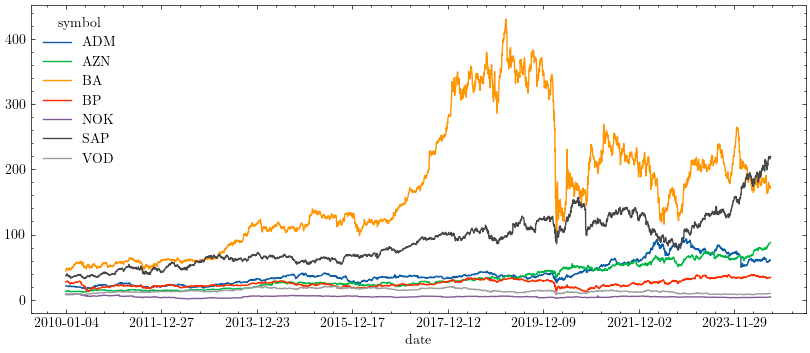

In [16]:
pivot[pivot.index>'2010-01-01'].plot(figsize=(10,4))

In [14]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2010-01-04,31.480000,31.840000,31.330000,21.440182,3472500,ADM,0
1,2010-01-04,23.709999,23.764999,23.575001,13.070818,2606200,AZN,0
2,2010-01-04,55.720001,56.389999,54.799999,43.777554,6186700,BA,0
3,2010-01-04,59.299999,59.450001,59.080002,27.320110,3956100,BP,0
4,2010-01-04,13.260000,13.450000,13.200000,8.098454,19884300,NOK,0


In [17]:
data = df.sort_values(['date','tic'],ignore_index=True)
data.index = data.index.factorize()[0]

In [18]:
covariances = []
returns = []

loopback = 252
for i in range(loopback,len(df.index.unique())):
    print(i)
    
data.head()

252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501


,date,open,high,low,close,volume,tic,day
0,2010-01-04,31.480000,31.840000,31.330000,21.440184,3472500,ADM,0
1,2010-01-04,23.709999,23.764999,23.575001,13.070818,2606200,AZN,0
2,2010-01-04,55.720001,56.389999,54.799999,43.777542,6186700,BA,0
3,2010-01-04,59.299999,59.450001,59.080002,27.320103,3956100,BP,0
4,2010-01-04,13.260000,13.450000,13.200000,8.098454,19884300,NOK,0


In [82]:
df.head()
df.dropna(inplace=True)

In [83]:
INDICATORS = [
    "close_21_sma",
]
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=False,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators


In [84]:
train_data = data_split(processed, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(processed, TEST_START_DATE, TEST_END_DATE)

In [85]:
display(train_data.tail(5))

,date,open,high,low,close,volume,tic,day,close_30_sma
3521,2023-12-29,260.670013,262.220001,259.559998,260.660004,3681900,BA,4,241.024667
3521,2023-12-29,35.380001,35.509998,35.279999,34.069370,3688000,BP,4,34.110112
3521,2023-12-29,3.370000,3.460000,3.340000,3.319488,21748700,NOK,4,3.251869
3521,2023-12-29,154.000000,155.059998,154.000000,152.674088,432200,SAP,4,153.660711
3521,2023-12-29,8.740000,8.740000,8.660000,8.275411,4442900,VOD,4,8.350494


In [86]:
print(len(train_data))
print(len(test_data))

24654
1176


In [87]:
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 7, State Space: 22


In [91]:
# Parameters for the environment
# env_kwargs = {
#     "hmax": 100, 
#     "num_stock_shares": [0] * stock_dimension,
#     "initial_amount": 1000000, 
#     "buy_cost_pct": [0.001] * stock_dimension,
#     "sell_cost_pct": [0.001] * stock_dimension,
#     "state_space": state_space, 
#     "stock_dim": stock_dimension, 
#     "tech_indicator_list": INDICATORS, 
#     "action_space": stock_dimension, 
#     "reward_scaling": 1e-4,
#     "make_plots" : True
    
# }
env_kwargs = {
    "hmax": 100, 
    "num_stock_shares": [0] * stock_dimension,
    "initial_amount": 1000000, 
    "buy_cost_pct": [0.001] * stock_dimension,
    "sell_cost_pct": [0.001] * stock_dimension,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": INDICATORS, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "make_plots" : False
    
}

#Establish the training environment using StockTradingEnv() class
e_train_gym = StockTradingEnv(df = train_data, **env_kwargs)

In [93]:
agent = DRLAgent(env = e_train_gym)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [94]:
ppo_agernt = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000)

----------------------------------
| time/              |           |
|    fps             | 186       |
|    iterations      | 1         |
|    time_elapsed    | 10        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 1.2304597 |
----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 3.52e+03     |
|    ep_rew_mean          | 67.5         |
| time/                   |              |
|    fps                  | 193          |
|    iterations           | 2            |
|    time_elapsed         | 21           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0040661106 |
|    clip_fraction        | 0.0456       |
|    clip_range           | 0.2          |
|    entropy_loss         | -9.94        |
|    explained_variance   | 2.9e-05      |
|    learning_rate        | 0.00025     

In [95]:
e_test_gym = StockTradingEnv(df = test_data, **env_kwargs)

hit end!


<Figure size 1500x500 with 0 Axes>

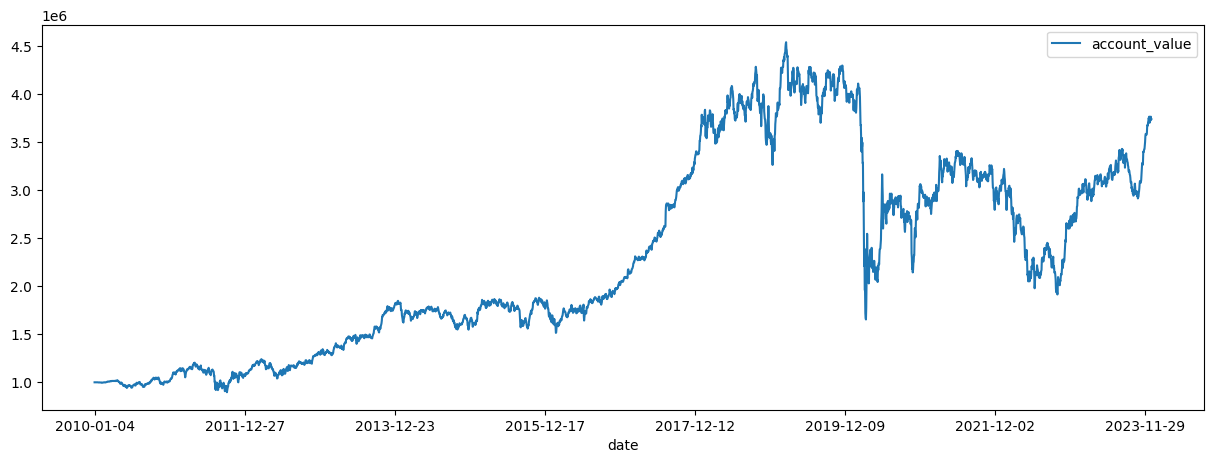

hit end!


<Axes: xlabel='date'>

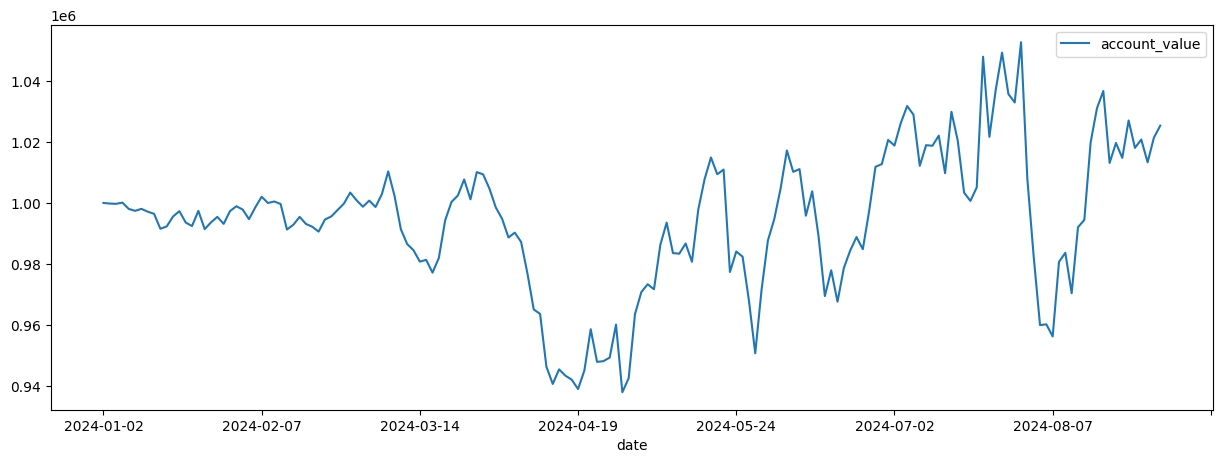

In [96]:
df_account_value_ppo_train, df_actions_ppo = DRLAgent.DRL_prediction(
    model=ppo_agernt, 
    environment = e_train_gym)
plt.figure()

df_result_ppo = df_account_value_ppo_train.set_index(df_account_value_ppo_train.columns[0])
plt.rcParams["figure.figsize"] = (15,5)
df_result_ppo.plot()
plt.show()
df_account_value_ppo_test, df_actions_ppo = DRLAgent.DRL_prediction(
    model=ppo_agernt, 
    environment = e_test_gym)
df_result_ppo = df_account_value_ppo_test.set_index(df_account_value_ppo_test.columns[0])
plt.rcParams["figure.figsize"] = (15,5)
df_result_ppo.plot()

In [97]:
backtest_stats(df_account_value_ppo_train)

Annual return          0.098996
Cumulative returns     2.740863
Annual volatility      0.258989
Sharpe ratio           0.495234
Calmar ratio           0.155720
Stability              0.734284
Max drawdown          -0.635732
Omega ratio            1.101958
Sortino ratio          0.693501
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.025198
Daily value at risk   -0.032121
dtype: float64


Annual return          0.098996
Cumulative returns     2.740863
Annual volatility      0.258989
Sharpe ratio           0.495234
Calmar ratio           0.155720
Stability              0.734284
Max drawdown          -0.635732
Omega ratio            1.101958
Sortino ratio          0.693501
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.025198
Daily value at risk   -0.032121
dtype: float64

In [98]:
backtest_stats(df_account_value_ppo_test)

Annual return          0.038219
Cumulative returns     0.025320
Annual volatility      0.172747
Sharpe ratio           0.304434
Calmar ratio           0.417120
Stability              0.061250
Max drawdown          -0.091625
Omega ratio            1.056229
Sortino ratio          0.424850
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.959337
Daily value at risk   -0.021555
dtype: float64


Annual return          0.038219
Cumulative returns     0.025320
Annual volatility      0.172747
Sharpe ratio           0.304434
Calmar ratio           0.417120
Stability              0.061250
Max drawdown          -0.091625
Omega ratio            1.056229
Sortino ratio          0.424850
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.959337
Daily value at risk   -0.021555
dtype: float64

[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (167, 8)


<Axes: >

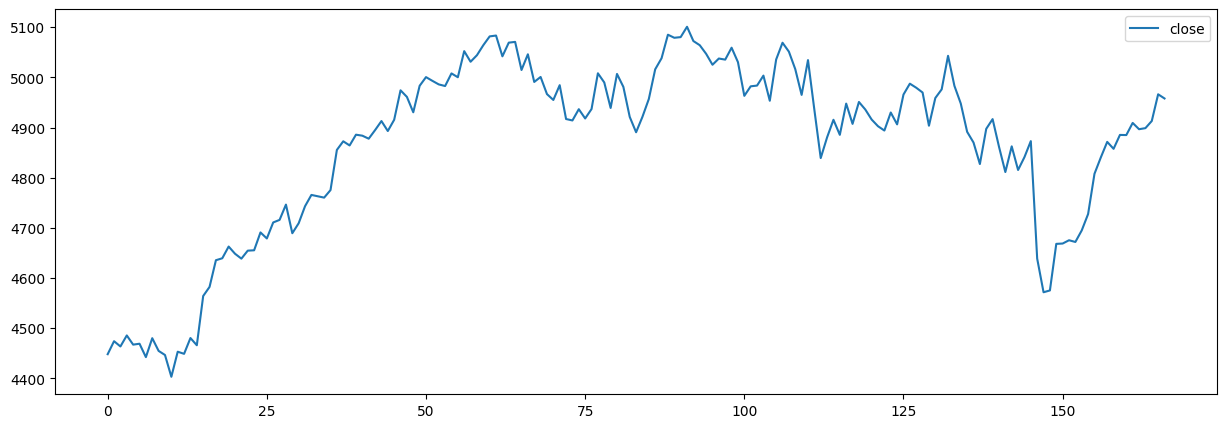

In [100]:
index_df = YahooDownloader(start_date = TEST_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = ['^STOXX50E']).fetch_data()
index_df = index_df[['date','close']]
fst_day = index_df['close'][0]
dji = pd.merge(index_df['date'], index_df['close'].div(fst_day).mul(1000000), 
               how='outer', left_index=True, right_index=True).set_index('date')
index_df.plot()

[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (3513, 8)


<Axes: >

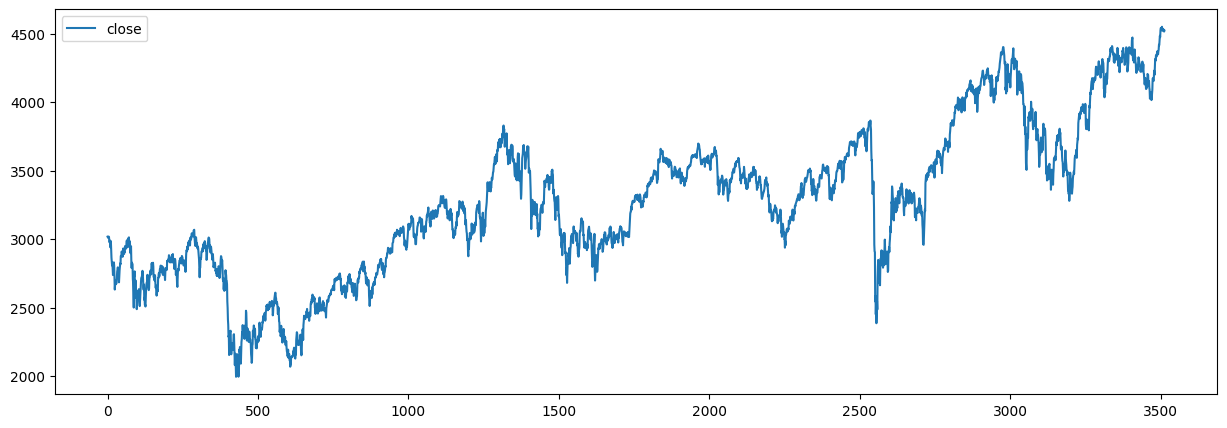

In [102]:
index_df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRAIN_END_DATE,
                     ticker_list = ['^STOXX50E']).fetch_data()
index_df = index_df[['date','close']]
fst_day = index_df['close'][0]
dji = pd.merge(index_df['date'], index_df['close'].div(fst_day).mul(1000000), 
               how='outer', left_index=True, right_index=True).set_index('date')
index_df.plot()

In [103]:
def DRL_prediction(model, environment, deterministic=True):
    """make a prediction and get results"""
    test_env, test_obs = environment.get_sb_env()
    account_memory = None  # This help avoid unnecessary list creation
    actions_memory = None  # optimize memory consumption
    state_memory= []

    test_env.reset()
    max_steps = len(environment.df.index.unique()) - 1

    for i in range(len(environment.df.index.unique())):
        action, _states = model.predict(test_obs, deterministic=deterministic)
        # account_memory = test_env.env_method(method_name="save_asset_memory")
        # actions_memory = test_env.env_method(method_name="save_action_memory")
        test_obs, rewards, dones, info = test_env.step(action)
        state_memory.append(test_obs[0])

        if (
            i == max_steps - 1
        ):  # more descriptive condition for early termination to clarify the logic
            account_memory = test_env.env_method(method_name="save_asset_memory")
            actions_memory = test_env.env_method(method_name="save_action_memory")
        # add current state to state memory
        # state_memory=test_env.env_method(method_name="save_state_memory")

        if dones[0]:
            print("hit end!")
            break
    return account_memory[0], actions_memory[0],state_memory

In [104]:
df_account_value_ppo_test, df_actions_ppo, states = DRL_prediction(
    model=ppo_agernt, 
    environment = e_test_gym)

hit end!


In [105]:
columns = ['acc_value']
columns.extend(train_data.tic.unique())
columns.extend(train_data.tic.unique() + ['_holding'])
columns.extend(train_data.tic.unique()+['_ma'])

print(len(columns))

22


In [114]:
states = np.array(states)
z = pd.DataFrame(states,columns= columns)
z.head()

,acc_value,ADM,AZN,BA,BP,NOK,SAP,VOD,ADM_holding,AZN_holding,...,NOK_holding,SAP_holding,VOD_holding,ADM_ma,AZN_ma,BA_ma,BP_ma,NOK_ma,SAP_ma,VOD_ma
0,987373.5000,71.248657,66.875084,243.910004,34.646816,3.290370,147.933578,8.427602,18.0,0.0,...,0.0,22.0,0.0,71.645844,63.820744,243.725662,34.138023,3.242162,153.708771,8.354484
1,974955.1875,69.904167,67.325356,244.940002,34.415836,3.348606,146.679321,8.522722,36.0,0.0,...,0.0,44.0,0.0,71.585434,63.983559,244.633331,34.134171,3.237633,153.551422,8.355597
2,962566.8125,68.988342,66.933815,249.000000,34.675690,3.338900,147.992844,8.541746,54.0,0.0,...,0.0,66.0,0.0,71.490608,64.117332,245.657669,34.143475,3.234721,153.464172,8.359751
3,950044.3750,69.231911,67.746262,229.000000,34.098244,3.435961,150.669250,8.570282,72.0,0.0,...,0.0,88.0,0.0,71.384407,64.300056,245.960663,34.148609,3.235045,153.444427,8.362921
4,938036.5625,68.851944,67.452614,225.759995,33.578537,3.377724,150.264328,8.484674,90.0,0.0,...,0.0,110.0,0.0,71.266525,64.443947,246.152664,34.118774,3.232780,153.377274,8.356263


['ADM', 'AZN', 'BA', 'BP', 'NOK', 'SAP', 'VOD']

In [127]:
holdings = np.array(z.iloc[:,1:stock_dimension+1]) * np.array(z.iloc[:,stock_dimension+2 :2*(stock_dimension+1)])
hoding_df = pd.DataFrame(holdings,columns=z.columns[1:stock_dimension+1].tolist())

<Axes: xlabel='date'>

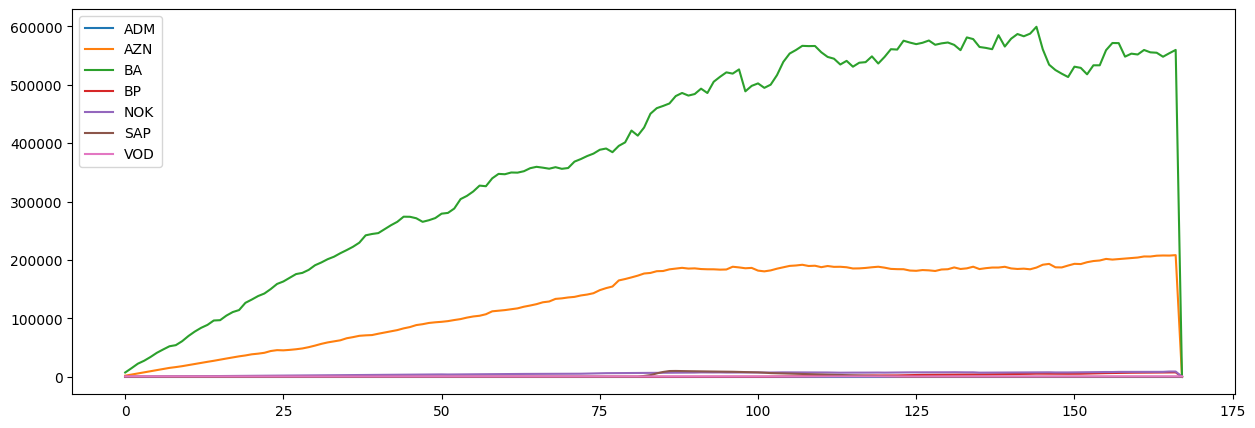

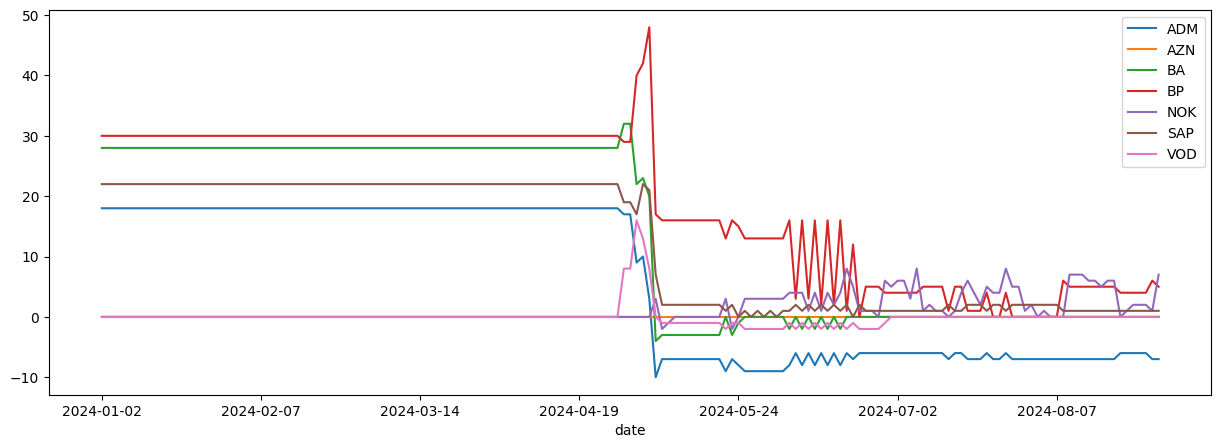

In [130]:
hoding_df.plot()
df_actions_ppo.plot()

In [107]:
a2c_model = agent.get_model("a2c")
trained_a2c = agent.train_model(model=a2c_model, 
                             tb_log_name='a2c',
                             total_timesteps=50000)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
--------------------------------------
| time/                 |            |
|    fps                | 144        |
|    iterations         | 100        |
|    time_elapsed       | 3          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -9.99      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -14.7      |
|    reward             | 0.05778634 |
|    std                | 1.01       |
|    value_loss         | 2.41       |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 149       |
|    iterations         | 200       |
|    time_elapsed       | 6         |
|    total_timesteps    | 1000   

hit end!


<Axes: xlabel='date'>

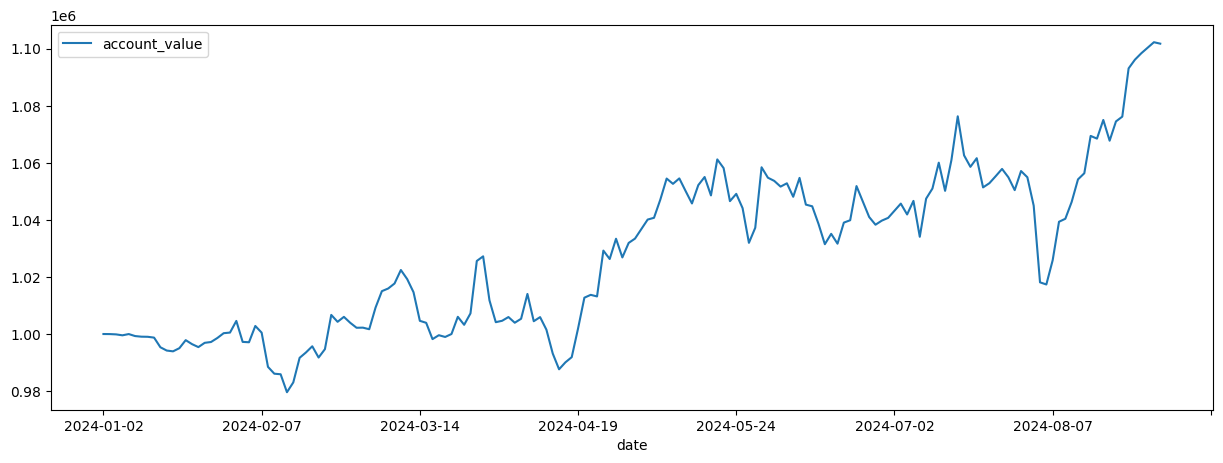

In [31]:

returns,actions = DRLAgent.DRL_prediction(model=trained_a2c, 
                             environment=e_test_gym
                            )
df_a2c = returns.set_index(returns.columns[0])
df_a2c.plot()

hit end!
day: 167, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 1098160.60
total_reward: 98160.60
total_cost: 2630.14
total_trades: 705
Sharpe: 0.802
hit end!


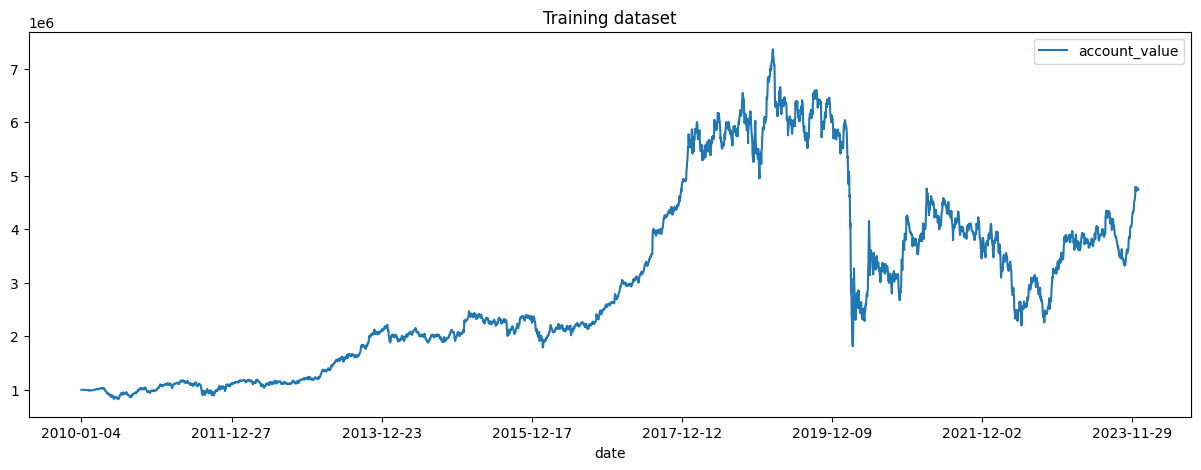

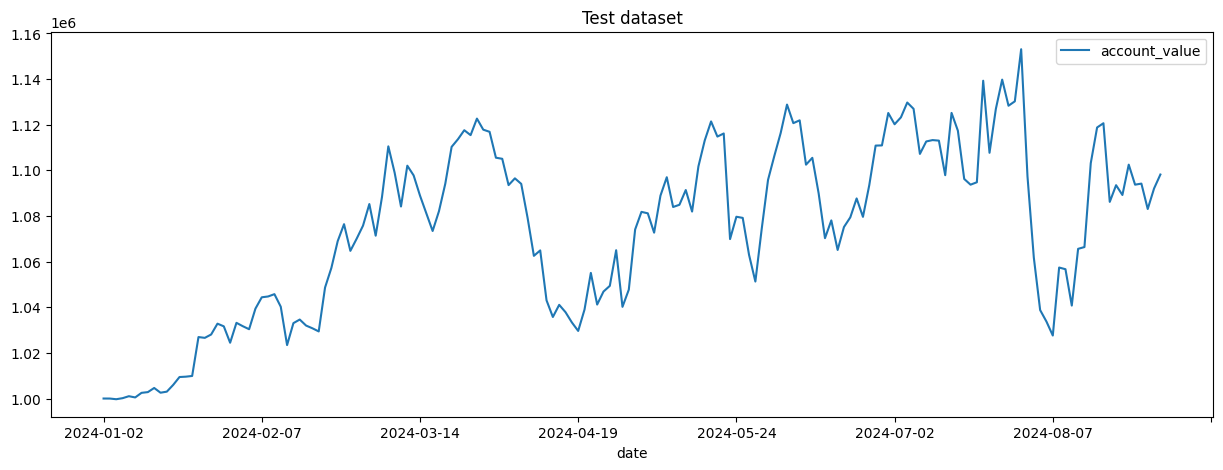

In [136]:
returns,actions,states = DRL_prediction(model=trained_a2c, 
                             environment=e_train_gym
                            )
df_a2c = returns.set_index(returns.columns[0])
df_a2c.plot(title = 'Training dataset')
returns,actions,states_test = DRL_prediction(model=trained_a2c, 
                             environment=e_test_gym
                            )
df_a2c = returns.set_index(returns.columns[0])
ax = df_a2c.plot(title = 'Test dataset')

<Axes: >

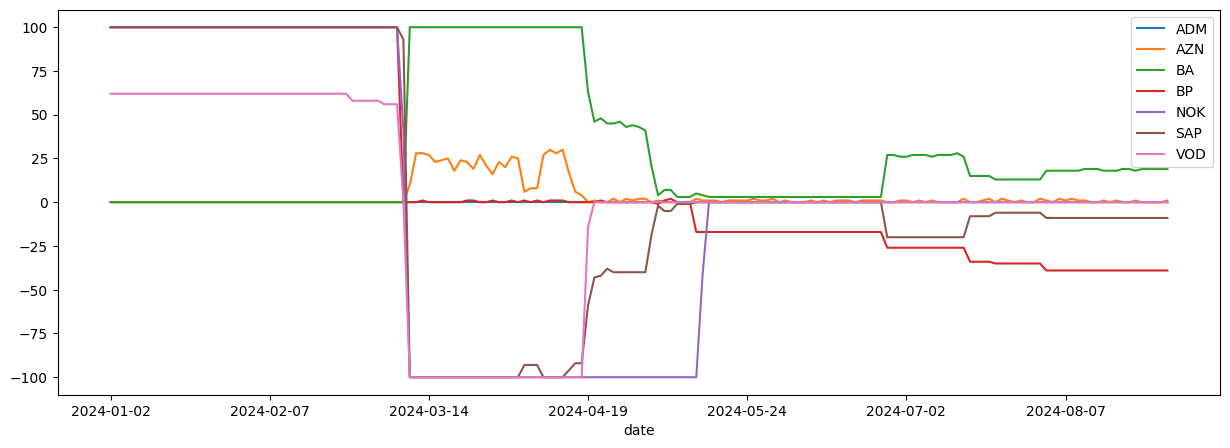

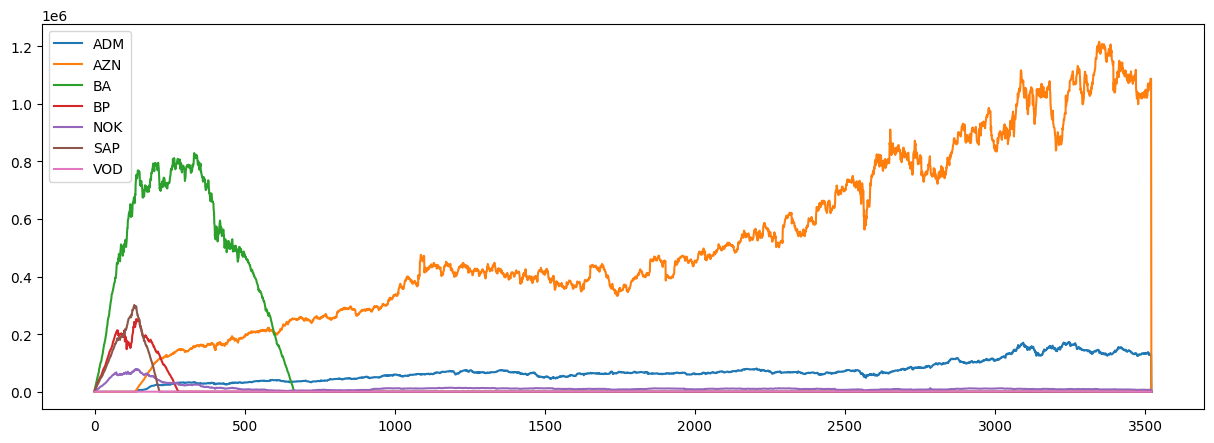

In [139]:

actions.plot()
states = np.array(states)
z2 = pd.DataFrame(states,columns= columns)
holdings = np.array(z2.iloc[:,1:stock_dimension+1]) * np.array(z2.iloc[:,stock_dimension+2 :2*(stock_dimension+1)])
hoding_df2 = pd.DataFrame(holdings,columns=z2.columns[1:stock_dimension+1].tolist())
hoding_df2.plot()
